# AI SHOPEASY PROJECT

by Marek Kmoch (286021) and Florian Neuhaus (286001)

for introduction, detailed comments, analysis of clusters and conclusion, see readme file

## Exploratory Data Analysis and Preprocessing

first, we import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

The code loads a csv file ShopEasy, which is where all of our data is located and loads it into a dataframe. The .head() function then shows the first 5 rows of our data, so we can check that our dataframe is working and that our data has been imported well.

In [2]:
shopeasy = pd.read_csv('shopEasy.csv')
shopeasy.head()

personId  accountTotal  frequencyIndex  itemCosts  singleItemCosts  \
0   C10573   1034.660626        0.833333    1308.11          1308.11   
1   C16889    777.853474        0.666667       0.00             0.00   
2   C12964     97.453056        0.818182     334.73           334.73   
3   C11171      0.000000        0.000000      12.65             0.00   
4   C17582     18.120946        0.500000      57.00            57.00   

   multipleItemCosts  emergencyFunds  itemBuyFrequency  \
0               0.00      234.602843          0.500000   
1               0.00     1820.143378          0.000000   
2               0.00       19.551802          0.083333   
3              12.65        0.000000          0.083333   
4               0.00        0.000000          0.166667   

   singleItemBuyFrequency  multipleItemBuyFrequency  ...  emergencyCount  \
0                0.500000                  0.000000  ...               1   
1                0.000000                  0.000000  ...               8   
2                0.083333                  0.000000  ...               1   
3                0.000000                  0.083333  ...               0   
4                0.166667                  0.000000  ...               0   

   itemCount  maxSpendLimit  monthlyPaid  leastAmountPaid  \
0          8         1500.0   236.764555       207.007715   
1          0         2000.0    89.741508       173.276205   
2          1         2500.0   234.271939       117.297542   
3          1         5000.0     0.000000              NaN   
4          1         1500.0   118.438703        54.138711   

   paymentCompletionRate  accountLifespan     location accountType webUsage  
0                   0.00                6     New York     Premium       60  
1                   0.00                6  Los Angeles     Premium        5  
2                   0.25               12     New York     Student       21  
3                   0.00               12      Chicago     Premium       53  
4                   0.00                6     New York     Premium       59  

[5 rows x 21 columns]

The duplicates are checked within the personID column, just to be perfectly safe that there are none and then their amount is printed out (it’s zero).

In [3]:
duplicates = shopeasy['personId'].duplicated().sum()
"Number of duplicated entries: " + str(duplicates)

'Number of duplicated entries: 0'

The amount of rows within the shopeasy dataframe is printed, so that we can compare the amount of rows with missing values to the actual total of rows later.

In [4]:
"Rows:", shopeasy.shape[0]

('Rows:', 8950)

The missing values are printed, so we can deal with them accordingly before we actually start forming clusters. Each column will tell us the amount of rows which have a missing value there.

In [5]:
shopeasy.isnull().sum()

personId                      0
accountTotal                  0
frequencyIndex                0
itemCosts                     0
singleItemCosts               0
multipleItemCosts             0
emergencyFunds                0
itemBuyFrequency              0
singleItemBuyFrequency        0
multipleItemBuyFrequency      0
emergencyUseFrequency         0
emergencyCount                0
itemCount                     0
maxSpendLimit                 1
monthlyPaid                   0
leastAmountPaid             313
paymentCompletionRate         0
accountLifespan               0
location                      0
accountType                   0
webUsage                      0
dtype: int64

This gives us the basic stats for every column, such as count, mean or standard deviation, so that we can examine if everything is in order and makes sense.

In [6]:
summary_stats = shopeasy.describe()
summary_stats

accountTotal  frequencyIndex     itemCosts  singleItemCosts  \
count   8950.000000     8950.000000   8950.000000      8950.000000   
mean    1564.474828        0.877271   1003.204834       592.437371   
std     2081.531879        0.236904   2136.634782      1659.887917   
min        0.000000        0.000000      0.000000         0.000000   
25%      128.281915        0.888889     39.635000         0.000000   
50%      873.385231        1.000000    361.280000        38.000000   
75%     2054.140036        1.000000   1110.130000       577.405000   
max    19043.138560        1.000000  49039.570000     40761.250000   

       multipleItemCosts  emergencyFunds  itemBuyFrequency  \
count        8950.000000     8950.000000       8950.000000   
mean          411.067645      978.871112          0.490351   
std           904.338115     2097.163877          0.401371   
min             0.000000        0.000000          0.000000   
25%             0.000000        0.000000          0.083333   
50%            89.000000        0.000000          0.500000   
75%           468.637500     1113.821139          0.916667   
max         22500.000000    47137.211760          1.000000   

       singleItemBuyFrequency  multipleItemBuyFrequency  \
count             8950.000000               8950.000000   
mean                 0.202458                  0.364437   
std                  0.298336                  0.397448   
min                  0.000000                  0.000000   
25%                  0.000000                  0.000000   
50%                  0.083333                  0.166667   
75%                  0.300000                  0.750000   
max                  1.000000                  1.000000   

       emergencyUseFrequency  emergencyCount    itemCount  maxSpendLimit  \
count            8950.000000     8950.000000  8950.000000    8949.000000   
mean                0.135144        3.248827    14.709832    4494.449450   
std                 0.200121        6.824647    24.857649    3638.815725   
min                 0.000000        0.000000     0.000000      50.000000   
25%                 0.000000        0.000000     1.000000    1600.000000   
50%                 0.000000        0.000000     7.000000    3000.000000   
75%                 0.222222        4.000000    17.000000    6500.000000   
max                 1.500000      123.000000   358.000000   30000.000000   

        monthlyPaid  leastAmountPaid  paymentCompletionRate  accountLifespan  \
count   8950.000000      8637.000000            8950.000000      8950.000000   
mean    1733.143852       864.206542               0.153715        11.517318   
std     2895.063757      2372.446607               0.292499         1.338331   
min        0.000000         0.019163               0.000000         6.000000   
25%      383.276166       169.123707               0.000000        12.000000   
50%      856.901546       312.343947               0.000000        12.000000   
75%     1901.134317       825.485459               0.142857        12.000000   
max    50721.483360     76406.207520               1.000000        12.000000   

          webUsage  
count  8950.000000  
mean     49.422570  
std      28.808219  
min       0.000000  
25%      24.000000  
50%      49.000000  
75%      74.000000  
max      99.000000

The function below outputs the percentage of data, which makes up each missing row. The function works by finding the total missing values, getting the percentage and making a table with the results, ordering them by missing descending values.

In [7]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")

        return mis_val_table_ren_columns

missing_values_table(shopeasy)

Your selected dataframe has 21 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
leastAmountPaid             313                3.5
maxSpendLimit                 1                0.0

This code transforms categorical variables within the shopeasy DataFrame into 1s (yes) and 0s (no), so that they can be interpreted by the clustering algorithms, as well as for our immediate graphs below. For example, location is turned into three columns, based on the three locations, New York, LA and Chicago. We then again print out the first 5 rows of the new dataframe to check.


In [8]:
shopeasy_df = pd.get_dummies(shopeasy, columns=['accountType'])
shopeasy_df = pd.get_dummies(shopeasy_df, columns=['location'])
shopeasy_df.head()

personId  accountTotal  frequencyIndex  itemCosts  singleItemCosts  \
0   C10573   1034.660626        0.833333    1308.11          1308.11   
1   C16889    777.853474        0.666667       0.00             0.00   
2   C12964     97.453056        0.818182     334.73           334.73   
3   C11171      0.000000        0.000000      12.65             0.00   
4   C17582     18.120946        0.500000      57.00            57.00   

   multipleItemCosts  emergencyFunds  itemBuyFrequency  \
0               0.00      234.602843          0.500000   
1               0.00     1820.143378          0.000000   
2               0.00       19.551802          0.083333   
3              12.65        0.000000          0.083333   
4               0.00        0.000000          0.166667   

   singleItemBuyFrequency  multipleItemBuyFrequency  ...  leastAmountPaid  \
0                0.500000                  0.000000  ...       207.007715   
1                0.000000                  0.000000  ...       173.276205   
2                0.083333                  0.000000  ...       117.297542   
3                0.000000                  0.083333  ...              NaN   
4                0.166667                  0.000000  ...        54.138711   

   paymentCompletionRate  accountLifespan  webUsage  accountType_Premium  \
0                   0.00                6        60                 True   
1                   0.00                6         5                 True   
2                   0.25               12        21                False   
3                   0.00               12        53                 True   
4                   0.00                6        59                 True   

   accountType_Regular  accountType_Student  location_Chicago  \
0                False                False             False   
1                False                False             False   
2                False                 True             False   
3                False                False              True   
4                False                False             False   

   location_Los Angeles  location_New York  
0                 False               True  
1                  True              False  
2                 False               True  
3                 False              False  
4                 False               True  

[5 rows x 25 columns]

The code below finds rows where the two columns which have missing values actually do have missing values, then selects the column values from the whole dataframe and turns them into a list, preparing them for histogram plotting by creating a figure for each shopeasy column. We then Plot distribution plots for each numeric column where maxSpendLimit or leastAmountPaid is missing. Since maxSpendLimit is only missing one row, we also draw a red line for the missing maxSpendLimit value and mark it. This, when compared to the actual plot distribution of the shopeasy dataset, will let us know if the data can be dropped or not.

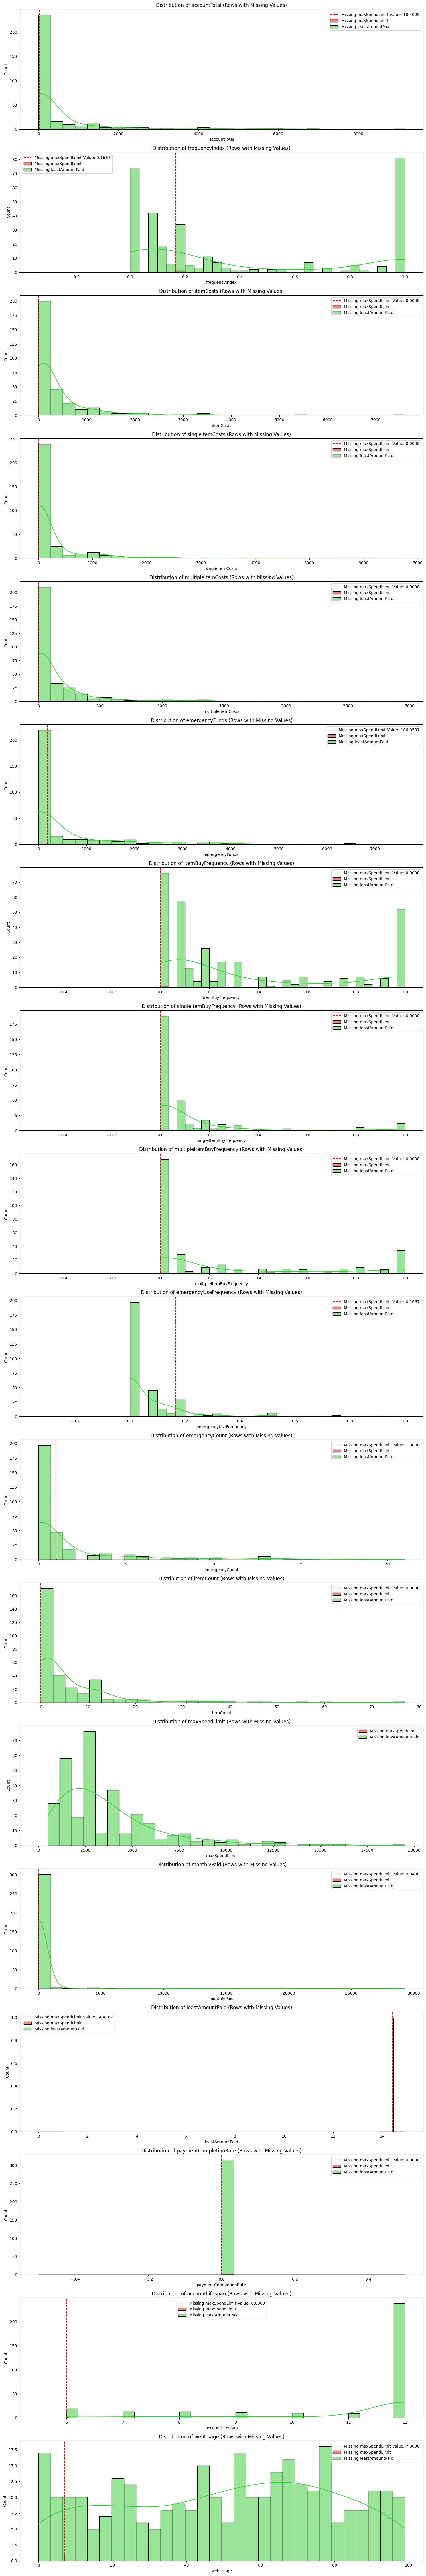

In [9]:

missing_maxSpendLimit_row = shopeasy_df[shopeasy_df['maxSpendLimit'].isnull()].iloc[0]
missing_maxSpendLimit_rows = shopeasy_df[shopeasy_df['maxSpendLimit'].isnull()]
missing_leastAmountPaid_rows = shopeasy_df[shopeasy_df['leastAmountPaid'].isnull()]

numeric_columns = shopeasy_df.select_dtypes(include='number').columns.tolist()

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(15, 5 * len(numeric_columns)))

for i, col in enumerate(numeric_columns):
    sns.histplot(data=missing_maxSpendLimit_rows, x=col, ax=axes[i], kde=True, bins=30, color='red', label='Missing maxSpendLimit', alpha=0.5)
    sns.histplot(data=missing_leastAmountPaid_rows, x=col, ax=axes[i], kde=True, bins=30, color='#32CD32', label='Missing leastAmountPaid', alpha=0.5)

    if pd.notna(missing_maxSpendLimit_row[col]):
        value = missing_maxSpendLimit_row[col]
        axes[i].axvline(value, color='red', linestyle='--', label=f'Missing maxSpendLimit Value: {value:.4f}')

    axes[i].set_title(f'Distribution of {col} (Rows with Missing Values)')
    axes[i].legend()

plt.tight_layout()
plt.show()

This directly correlates to the visual above. We draw distribution plots for all of the data, so that we can compare them to the missing value column data and decide what to do with Null values.

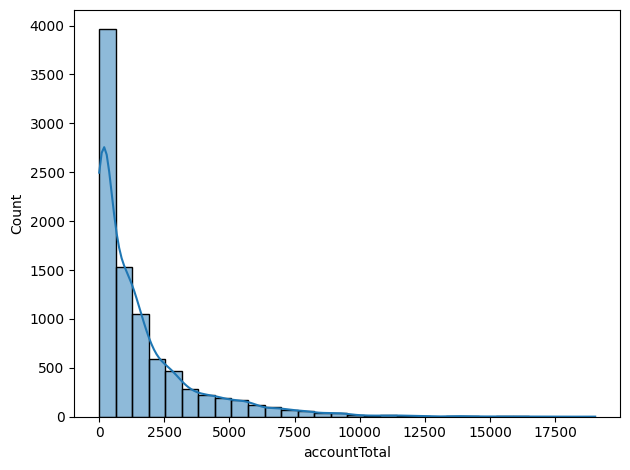

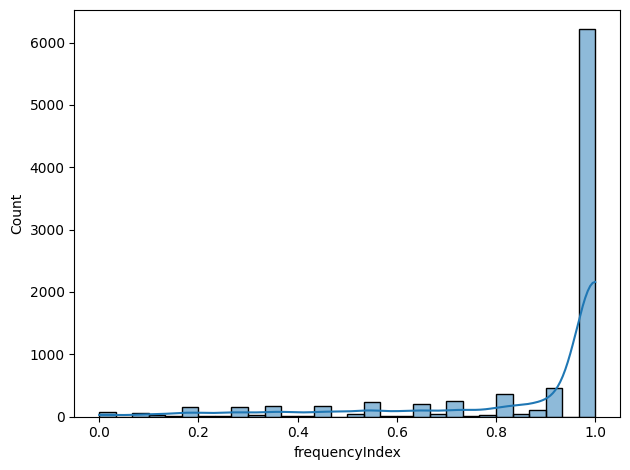

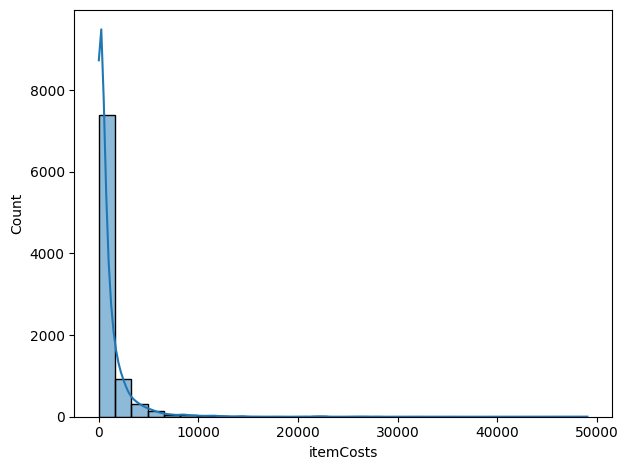

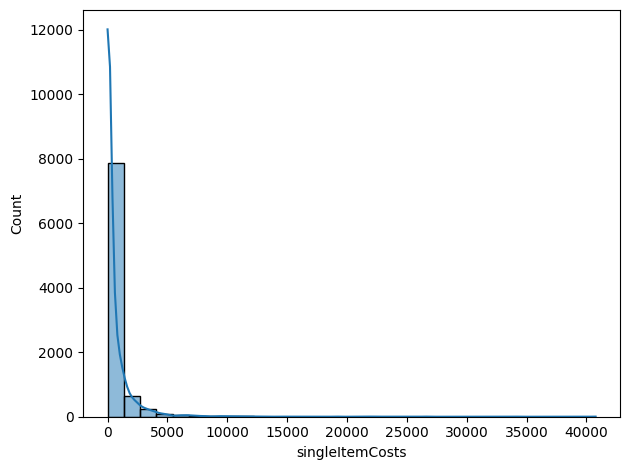

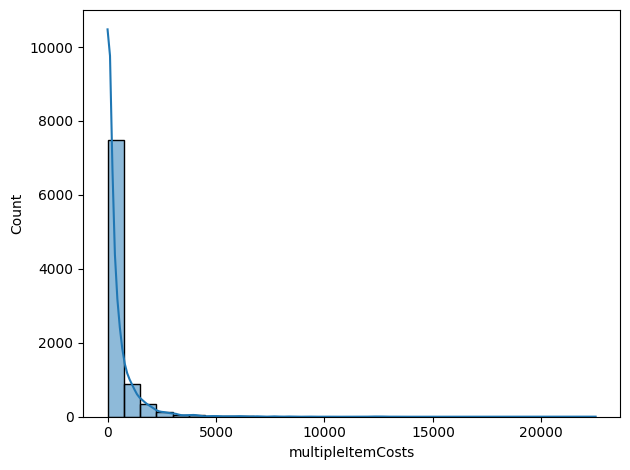

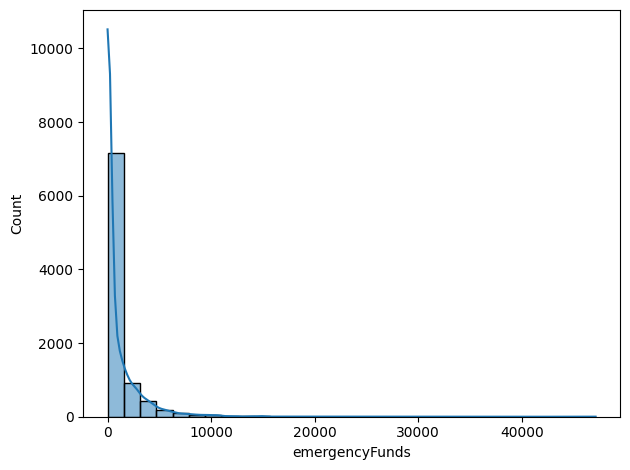

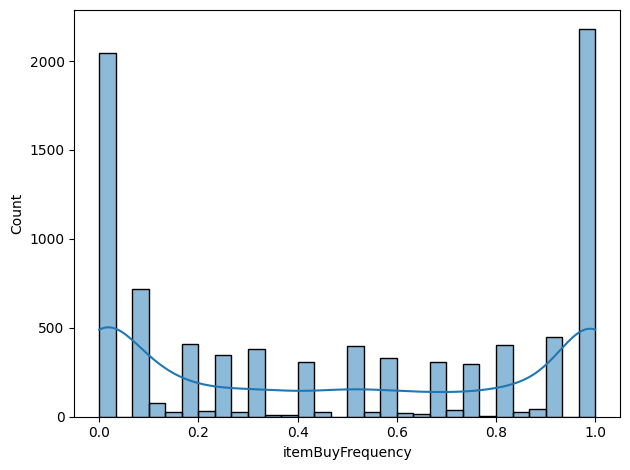

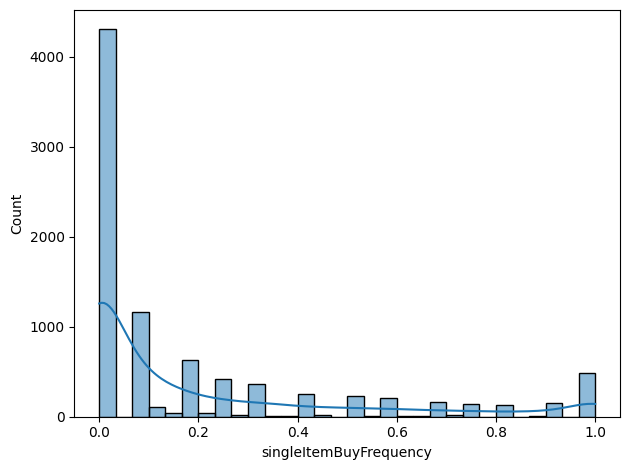

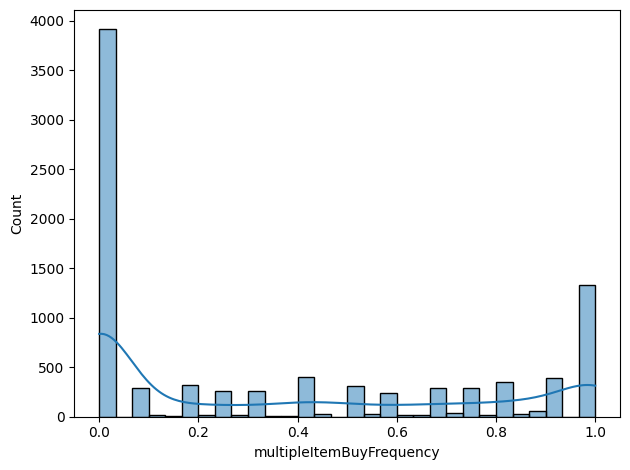

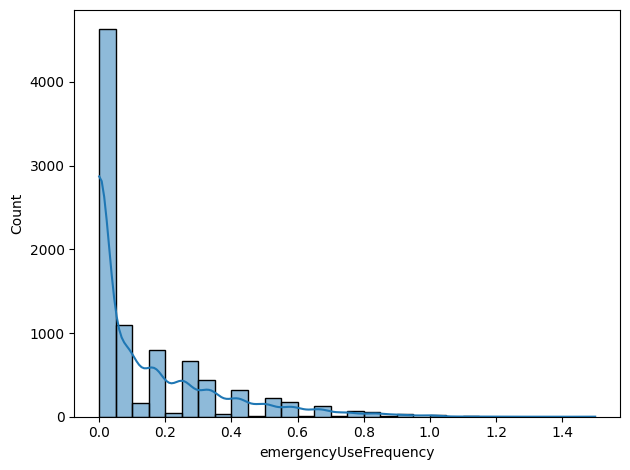

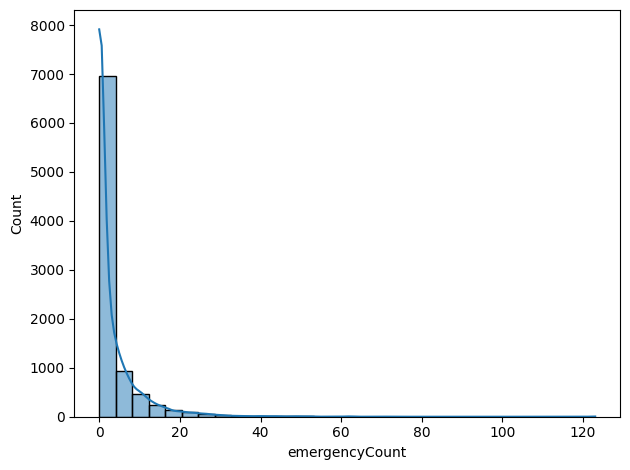

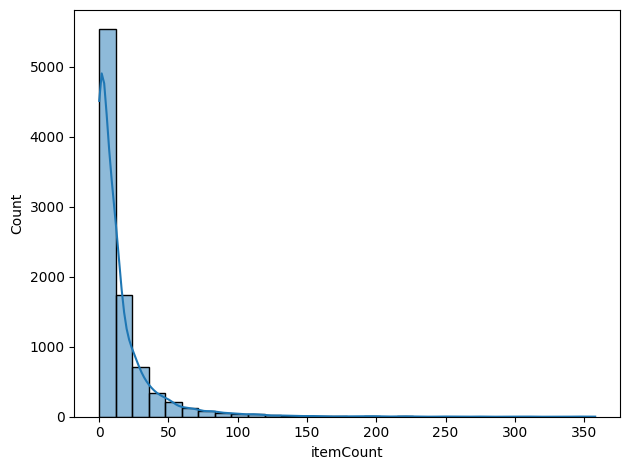

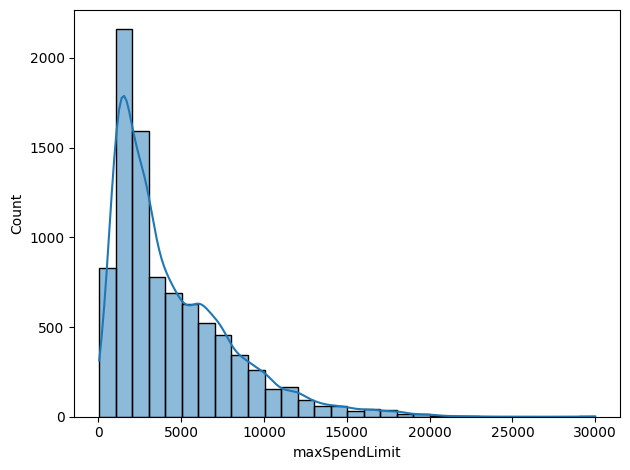

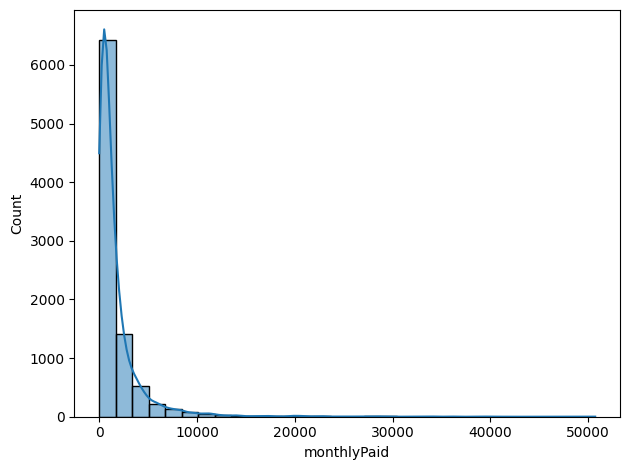

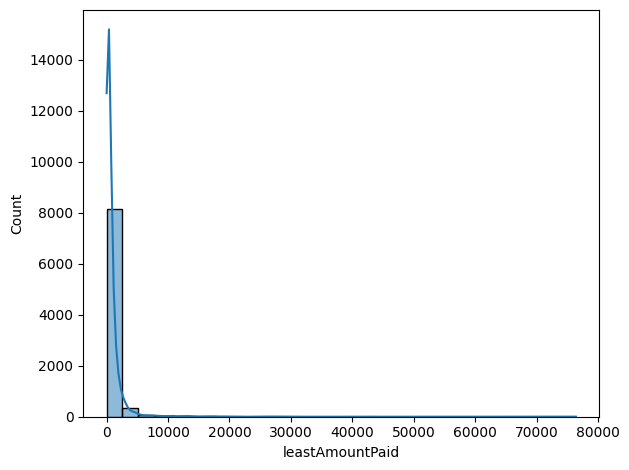

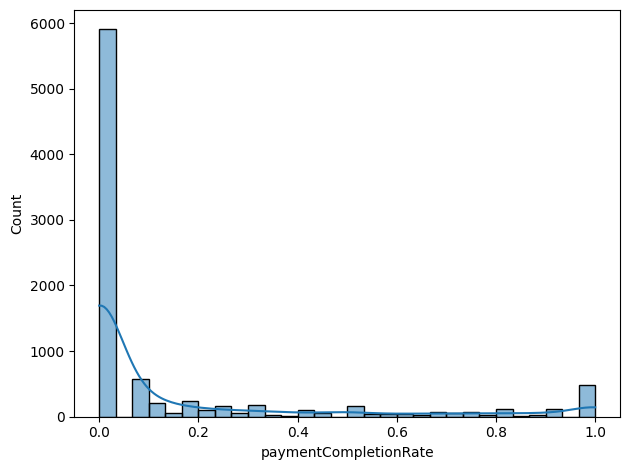

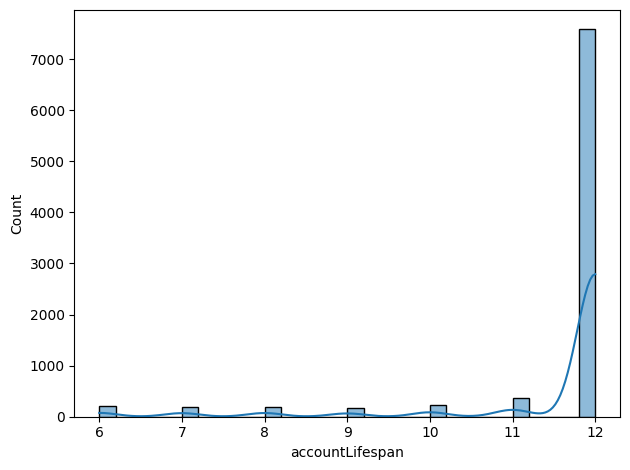

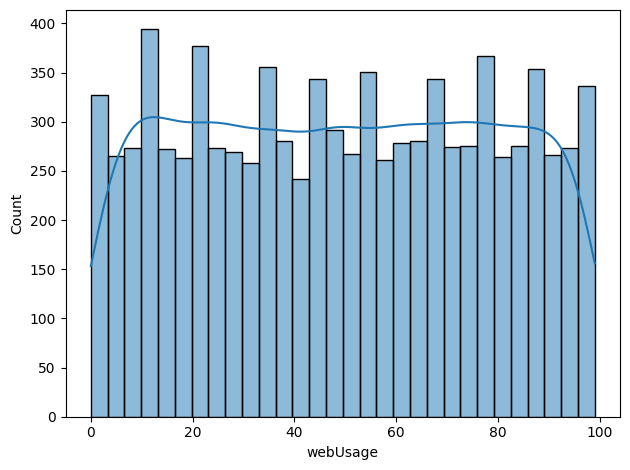

In [10]:
numeric_columns = shopeasy_df.select_dtypes(include='number').columns.tolist()

for i, col in enumerate(numeric_columns):
    sns.histplot(data=shopeasy_df, x=col, kde=True, bins=30,alpha=0.5)

    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

    plt.tight_layout()
    plt.show()

Since the two distributions compared are very similar, we decided to drop the rows with missing columns, which is what the code below does. We also print out the amount of rows dropped and the percentage it is when compared to the whole data, so that we can reiterate that it actually isn’t much (3.44% of data).

In [11]:
original_length = len(shopeasy_df)
shopeasy_df = shopeasy_df.dropna()
new_length = len(shopeasy_df)

rows_dropped = original_length - new_length

f"Number of Rows Dropped: {rows_dropped}, which is {(rows_dropped/ original_length) * 100}%"

'Number of Rows Dropped: 314, which is 3.5083798882681565%'

The code below helps us combine the three types of accounts, which used to be categories, into a singular graph, so that their distribution can be visualized at the same time. We notice that the distribution between the three account types is nearly the same.

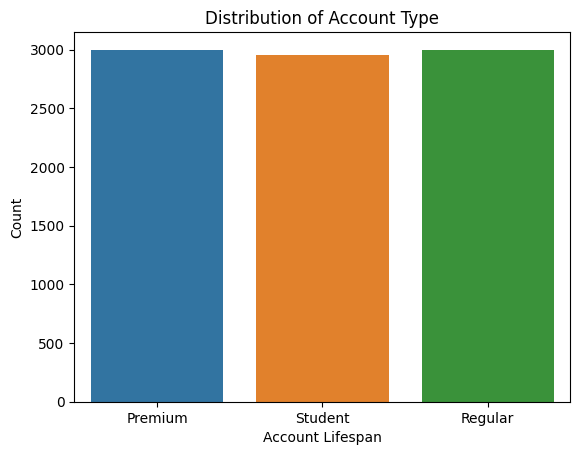

In [12]:
sns.countplot(data=shopeasy, x='accountType', hue= "accountType")
plt.title('Distribution of Account Type')
plt.xlabel('Account Lifespan')
plt.ylabel('Count')
plt.show()

This does the exact same thing as the code above, but for the three locations instead. We notice that the distribution between the three locations is nearly the same.

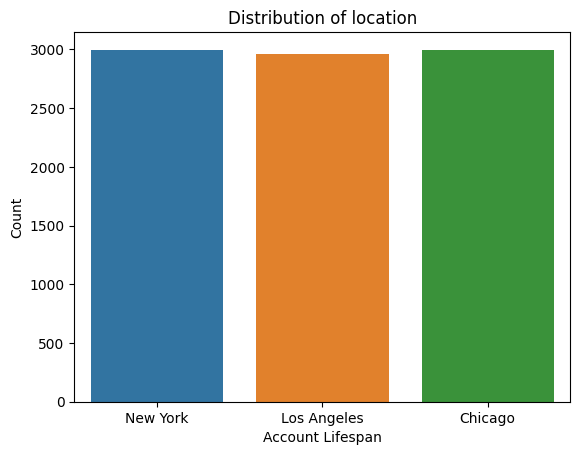

In [13]:
sns.countplot(data=shopeasy, x='location', hue ="location")
plt.title('Distribution of location')
plt.xlabel('Account Lifespan')
plt.ylabel('Count')
plt.show()

The code creates correlation pairplots with some interesting variables compared to the account types, so that we can decide if there is a correlation at all or if the rows can be dropped later on. From the visuals below, we can see that there does not seem to be a correlation between accountType and the different variables, but we will still decide to keep these variables. More on the reasoning behind this decision is annotated in the readme file. The pairplots give us some initial intution of how the data may correlate, but the correlations will be further elaborated upon further below.


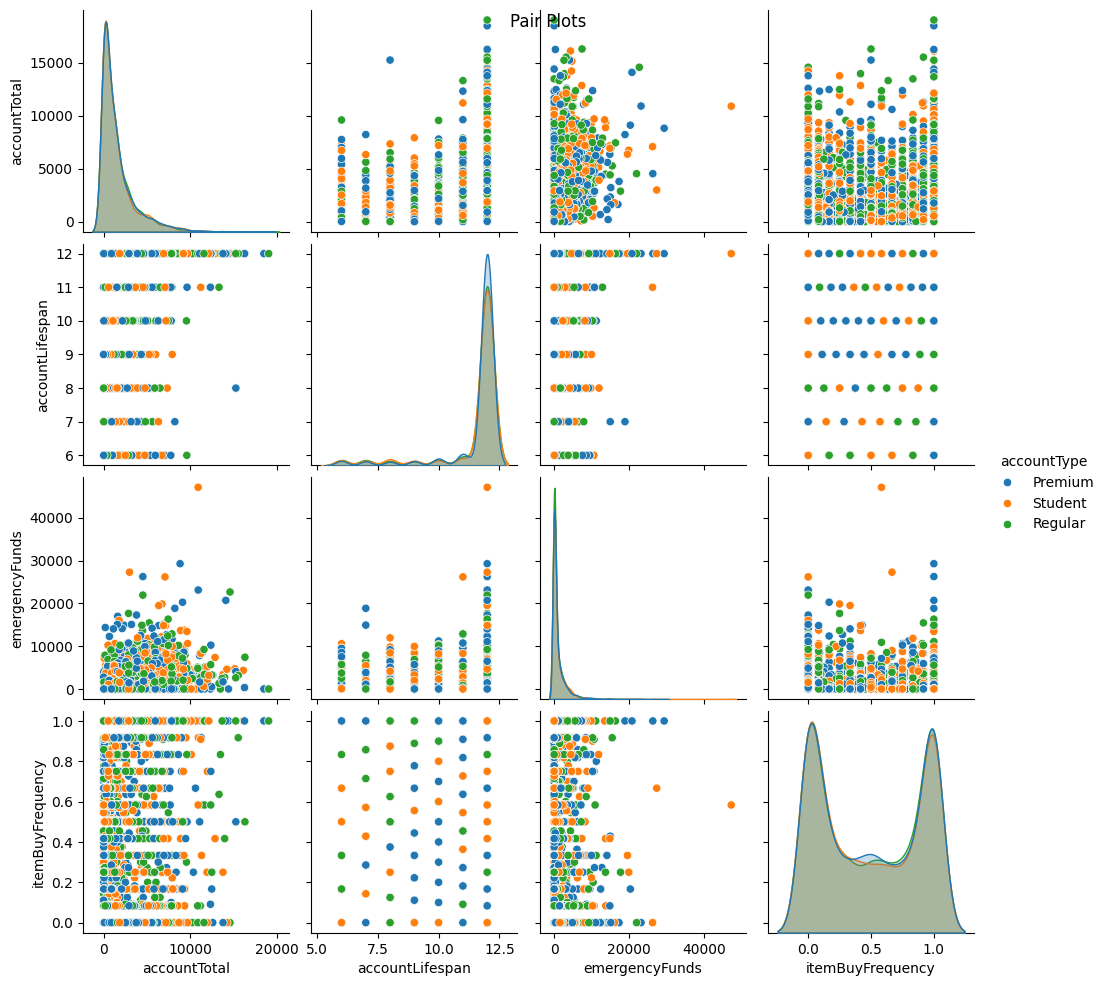

In [14]:
sns.pairplot(shopeasy, vars=["accountTotal", "accountLifespan", 'emergencyFunds', "itemBuyFrequency"], hue='accountType')
plt.suptitle("Pair Plots")
plt.show()

Below is code to create a Kernel Density Estimate function, which shows the three account types and how they’re distributed, when compared to one another and the accountTotal column. We chose the account total, as this describes how much the customer has spent on the website as a total and we therefore deem it to be the most important measurement overall. We confirm the suspicion mentioned above: We can see that there is no difference in the account types and their accountTotal.

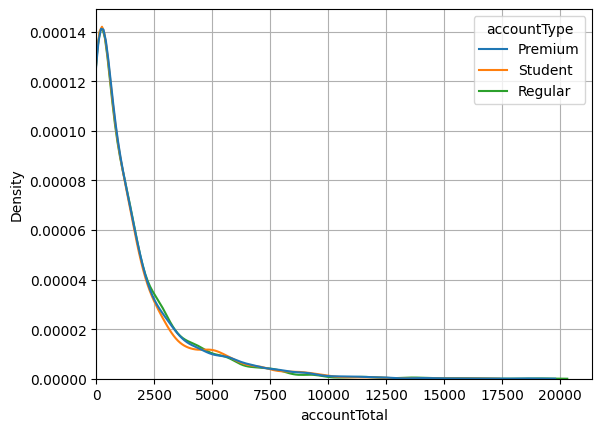

In [15]:
ax = sns.kdeplot(data= shopeasy, x = "accountTotal", hue='accountType', multiple='layer')
ax.set_xlim(0,None)
ax.grid()

The exact same KDE function is done below, but for the different locations. We notice that there is no difference between the locations and the account total.

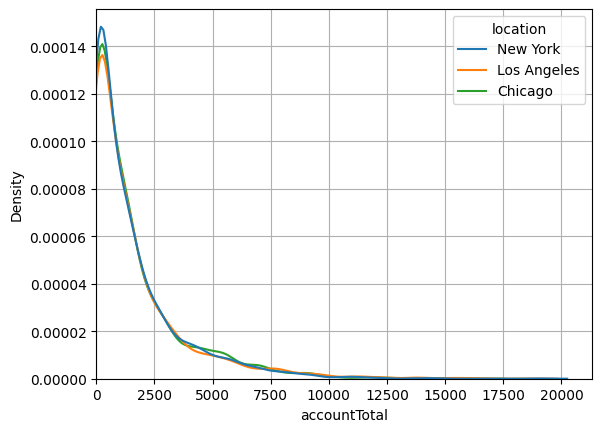

In [16]:
ax = sns.kdeplot(data= shopeasy, x = "accountTotal", hue='location', multiple='layer')
ax.set_xlim(0,None)
ax.grid()

The code below creates the correlation heatmap. The visual represents the correlation between all of the different feature columns that we are dealing with. Both the x and y axis are the different data attributes. This will help us decide what values we would like to drop and which we will keep, based on if they correlate with anything at all, or if they correlate so much with another attribute that they do not provide any additional insight.
We immediately decide, that since we are dealing with an E-Commerce company, to drop the three columns which describe the location of the customer, as the local position of the customer will not be valuable for segmentation and there is de facto no correlation between the location and any other attribute.
In addition, we notice that there is a very strong correlation between values such as ItemBuyFrequency, multipleItemBuyFrequency and singleItemBuyFrequency, as well as between emergencyCount and emergencyUseFrequency, which is why we will drop some of those features as they provide no additional insight. More on that decision process can be found in the readme file.

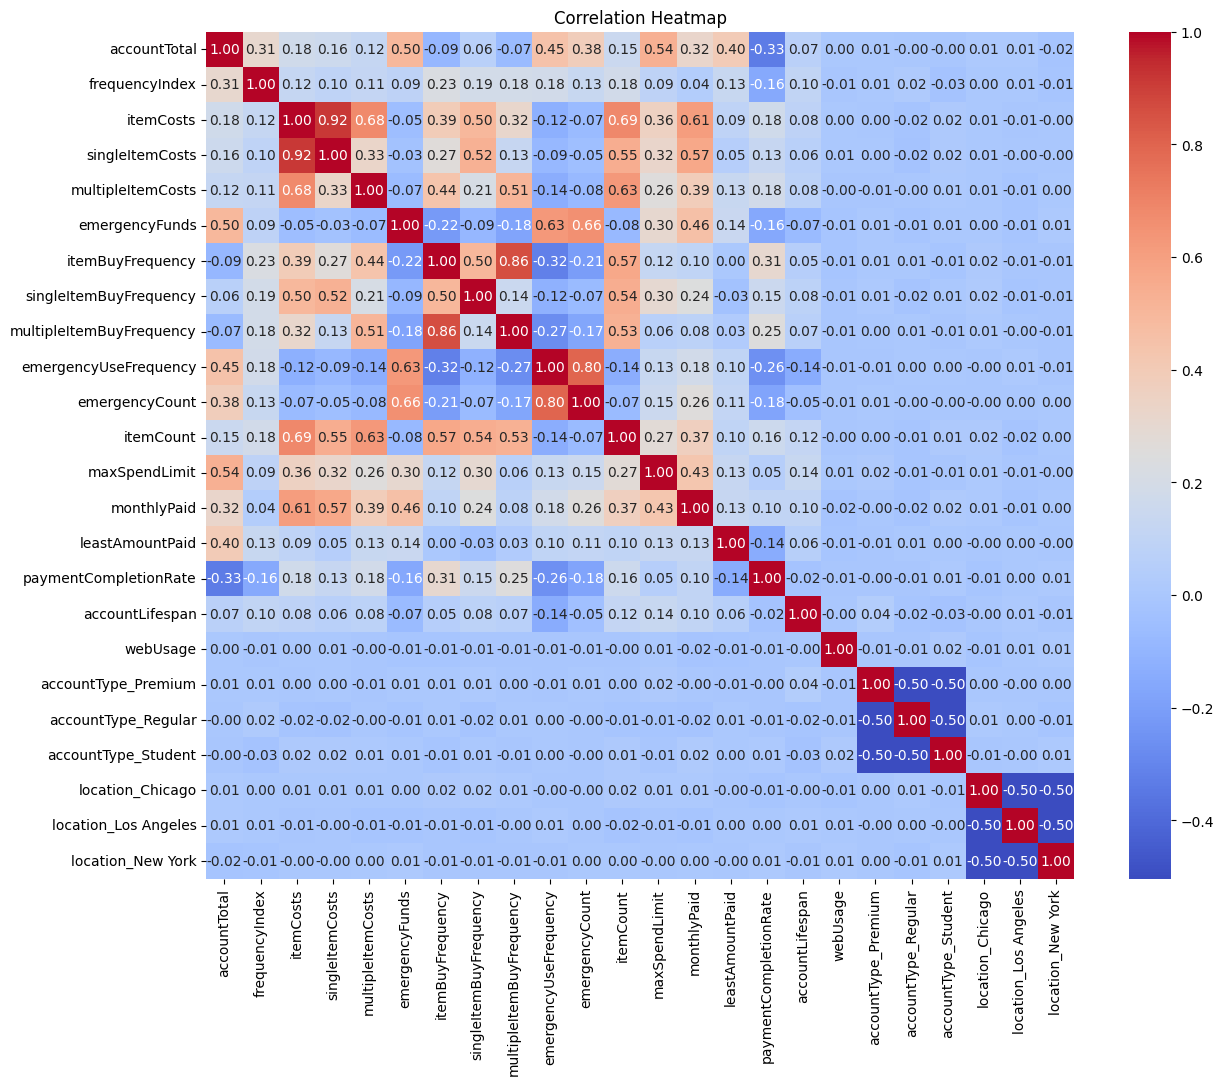

In [17]:
shopeasy_df = shopeasy_df.drop(["personId"], axis=1)
correlation_matrix = shopeasy_df.corr()
plt.figure(figsize=(14, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

This drops our personID column and then scales our data, using the standard scaler so that it can be used for the clustering models. Scaling the data actually just computes the mean and standard deviation of each column feature and scales them such that they have a mean of 0 and a standard deviation of 1. The first five rows of the scaled dataframe are printed, so that we can see if our process worked.

In [18]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(shopeasy_df)

scaled_df = pd.DataFrame(scaled_data, columns=shopeasy_df.columns)

scaled_df.head()

accountTotal  frequencyIndex  itemCosts  singleItemCosts  \
0     -0.270378       -0.297095   0.130447         0.417530   
1     -0.392933       -1.099590  -0.473208        -0.359160   
2     -0.717637       -0.370047  -0.318740        -0.160414   
3     -0.755496       -1.902089  -0.446904        -0.325317   
4     -0.535632        0.505405   0.016408         0.258928   

   multipleItemCosts  emergencyFunds  itemBuyFrequency  \
0          -0.458839       -0.358063          0.009969   
1          -0.458839        0.389362         -1.236139   
2          -0.458839       -0.459439         -1.028455   
3          -0.458839       -0.468655         -0.820769   
4          -0.437033       -0.468655         -0.820769   

   singleItemBuyFrequency  multipleItemBuyFrequency  emergencyUseFrequency  \
0                0.980186                 -0.926522               0.144032   
1               -0.686280                 -0.926522               1.795997   
2               -0.408536                 -0.926522              -0.268963   
3               -0.130790                 -0.926522              -0.681953   
4               -0.408536                 -0.717179              -0.681953   

   ...  leastAmountPaid  paymentCompletionRate  accountLifespan  webUsage  \
0  ...        -0.277057              -0.537727        -4.221800  0.368316   
1  ...        -0.291275              -0.537727        -4.221800 -1.541019   
2  ...        -0.314870               0.306144         0.355181 -0.985576   
3  ...        -0.341492              -0.537727        -4.221800  0.333601   
4  ...        -0.276402              -0.537727         0.355181  0.229456   

   accountType_Premium  accountType_Regular  accountType_Student  \
0             1.408217             -0.70809            -0.703119   
1             1.408217             -0.70809            -0.703119   
2            -0.710118             -0.70809             1.422235   
3             1.408217             -0.70809            -0.703119   
4             1.408217             -0.70809            -0.703119   

   location_Chicago  location_Los Angeles  location_New York  
0         -0.709749             -0.702200           1.409681  
1         -0.709749              1.424096          -0.709380  
2         -0.709749             -0.702200           1.409681  
3         -0.709749             -0.702200           1.409681  
4         -0.709749             -0.702200           1.409681  

[5 rows x 24 columns]

## Feature Selection

This code drops all of the columns that we do not want to use for our clustering algorithms (touched upon above and explained in Section 2 of our readme). We create sclaed_df2 to use on K-Means and we create two copies, scaled_df3 and scaled_df4, to be used in DBScan hierarchical clustering.

In [19]:
scaled_df2 = scaled_df.drop("location_New York", axis = 1)
scaled_df2 = scaled_df2.drop("location_Los Angeles", axis = 1)
scaled_df2 = scaled_df2.drop("location_Chicago", axis = 1)
scaled_df2 = scaled_df2.drop("webUsage", axis = 1)
scaled_df2 = scaled_df2.drop("singleItemBuyFrequency", axis = 1)
scaled_df2 = scaled_df2.drop("multipleItemBuyFrequency", axis = 1)
scaled_df2 = scaled_df2.drop("multipleItemCosts", axis = 1)
scaled_df2 = scaled_df2.drop("singleItemCosts", axis = 1)
scaled_df2 = scaled_df2.drop("leastAmountPaid", axis = 1)
scaled_df2 = scaled_df2.drop("frequencyIndex", axis = 1)
scaled_df2 = scaled_df2.drop("paymentCompletionRate", axis = 1)
scaled_df2 = scaled_df2.drop("emergencyCount", axis = 1)
scaled_df2 = scaled_df2.drop("maxSpendLimit", axis = 1)
scaled_df3 = scaled_df2
scaled_df4 = scaled_df2

Below is the correlation map once again, but just for the values we are using for clustering. As we can see, there is at least some correlation between all, but the account types. We have explained why we kept the account types in the readme file.

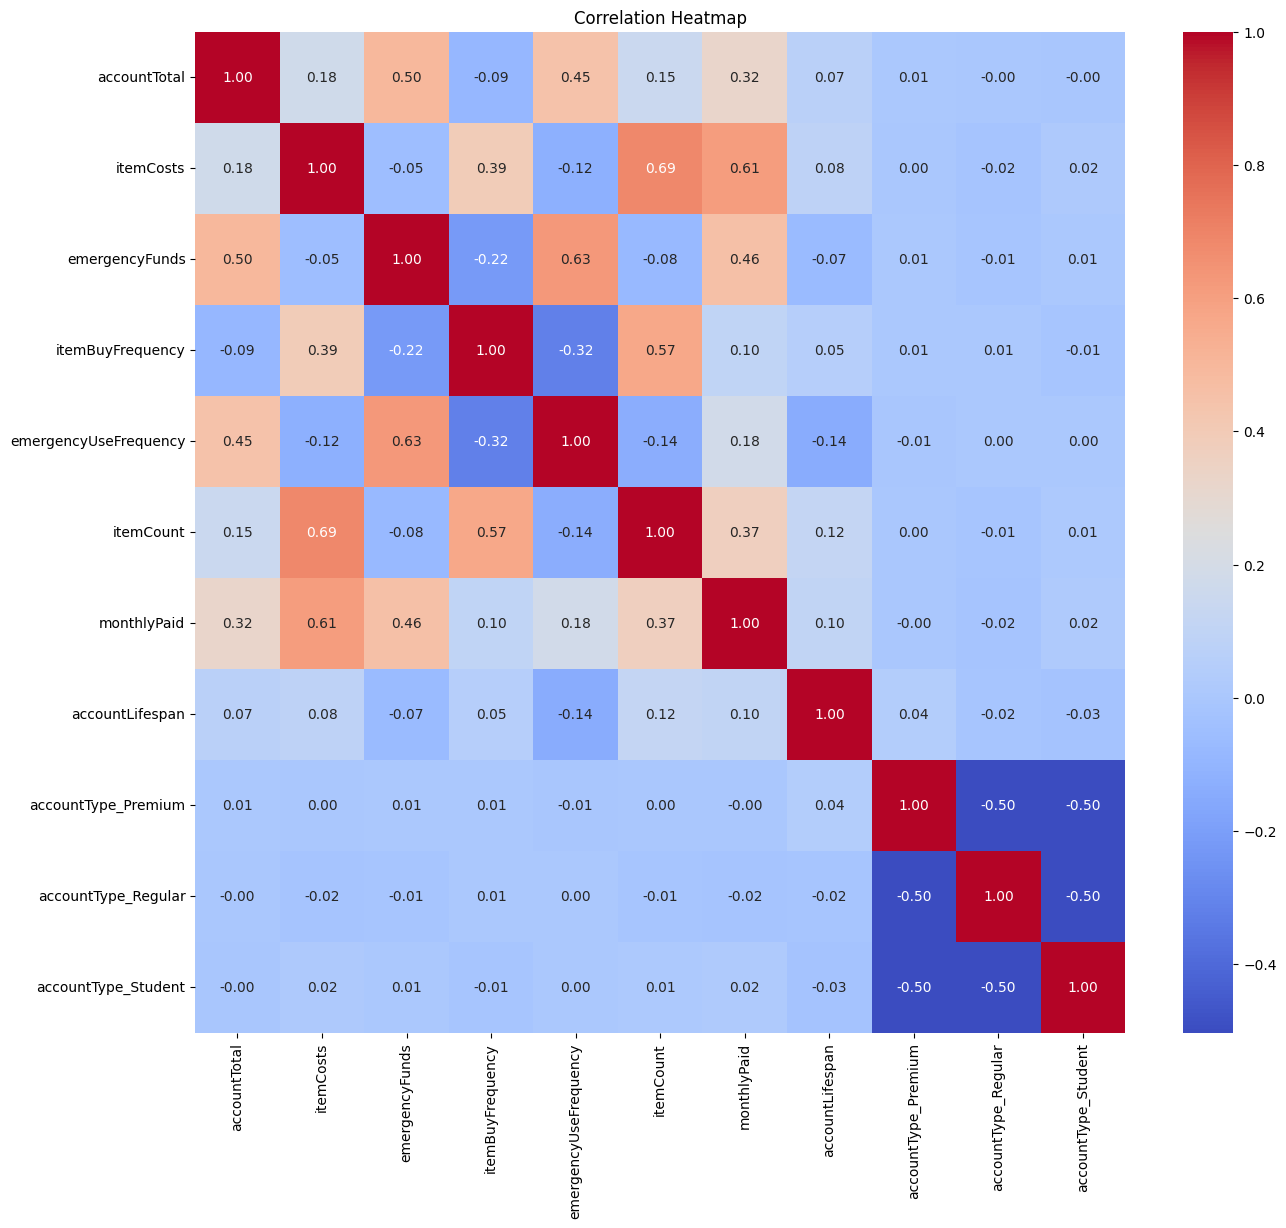

In [20]:
correlation_matrix = scaled_df2.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Clustering Method 1: K-Means++ 

This is the start of K-Means Clustering++. The code below compares the ineratia of the different amounts of clusters one may choose. We will then use the Elbow Method to determine the correct amount of custers we should use to both minimize clusters and inertia. The elbow method is explained more thoroughly in section 3 of the readme file. We ultimately detect that we should use 5 clusters.

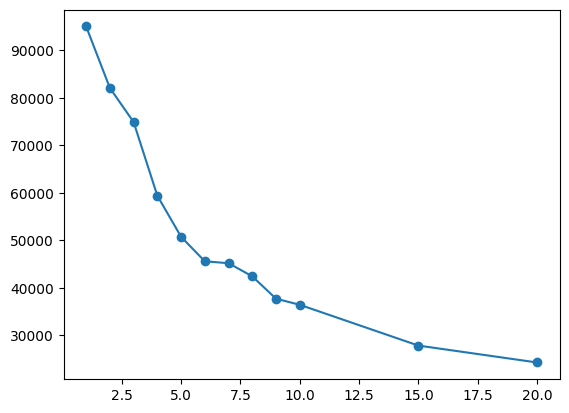

In [21]:
fig, ax = plt.subplots()

n_clusters = [1,2,3,4,5,6,7,8,9,10,15,20]

inertias = []
for n_cluster in n_clusters:
  model = KMeans(n_clusters = n_cluster, n_init = 'auto', init = 'k-means++')
  model.fit(scaled_df2)
  inertias.append(model.inertia_)

ax.scatter(n_clusters, inertias)
ax.plot(n_clusters, inertias)

We create five different clusters with K-Means Clustering++, based on the elbow in the elbow method graph above. We also go ahead and create pairplots for all of our features (x-axis and y-axis), so that we can show all five different clusters mapped to the different features. This is displayed below.

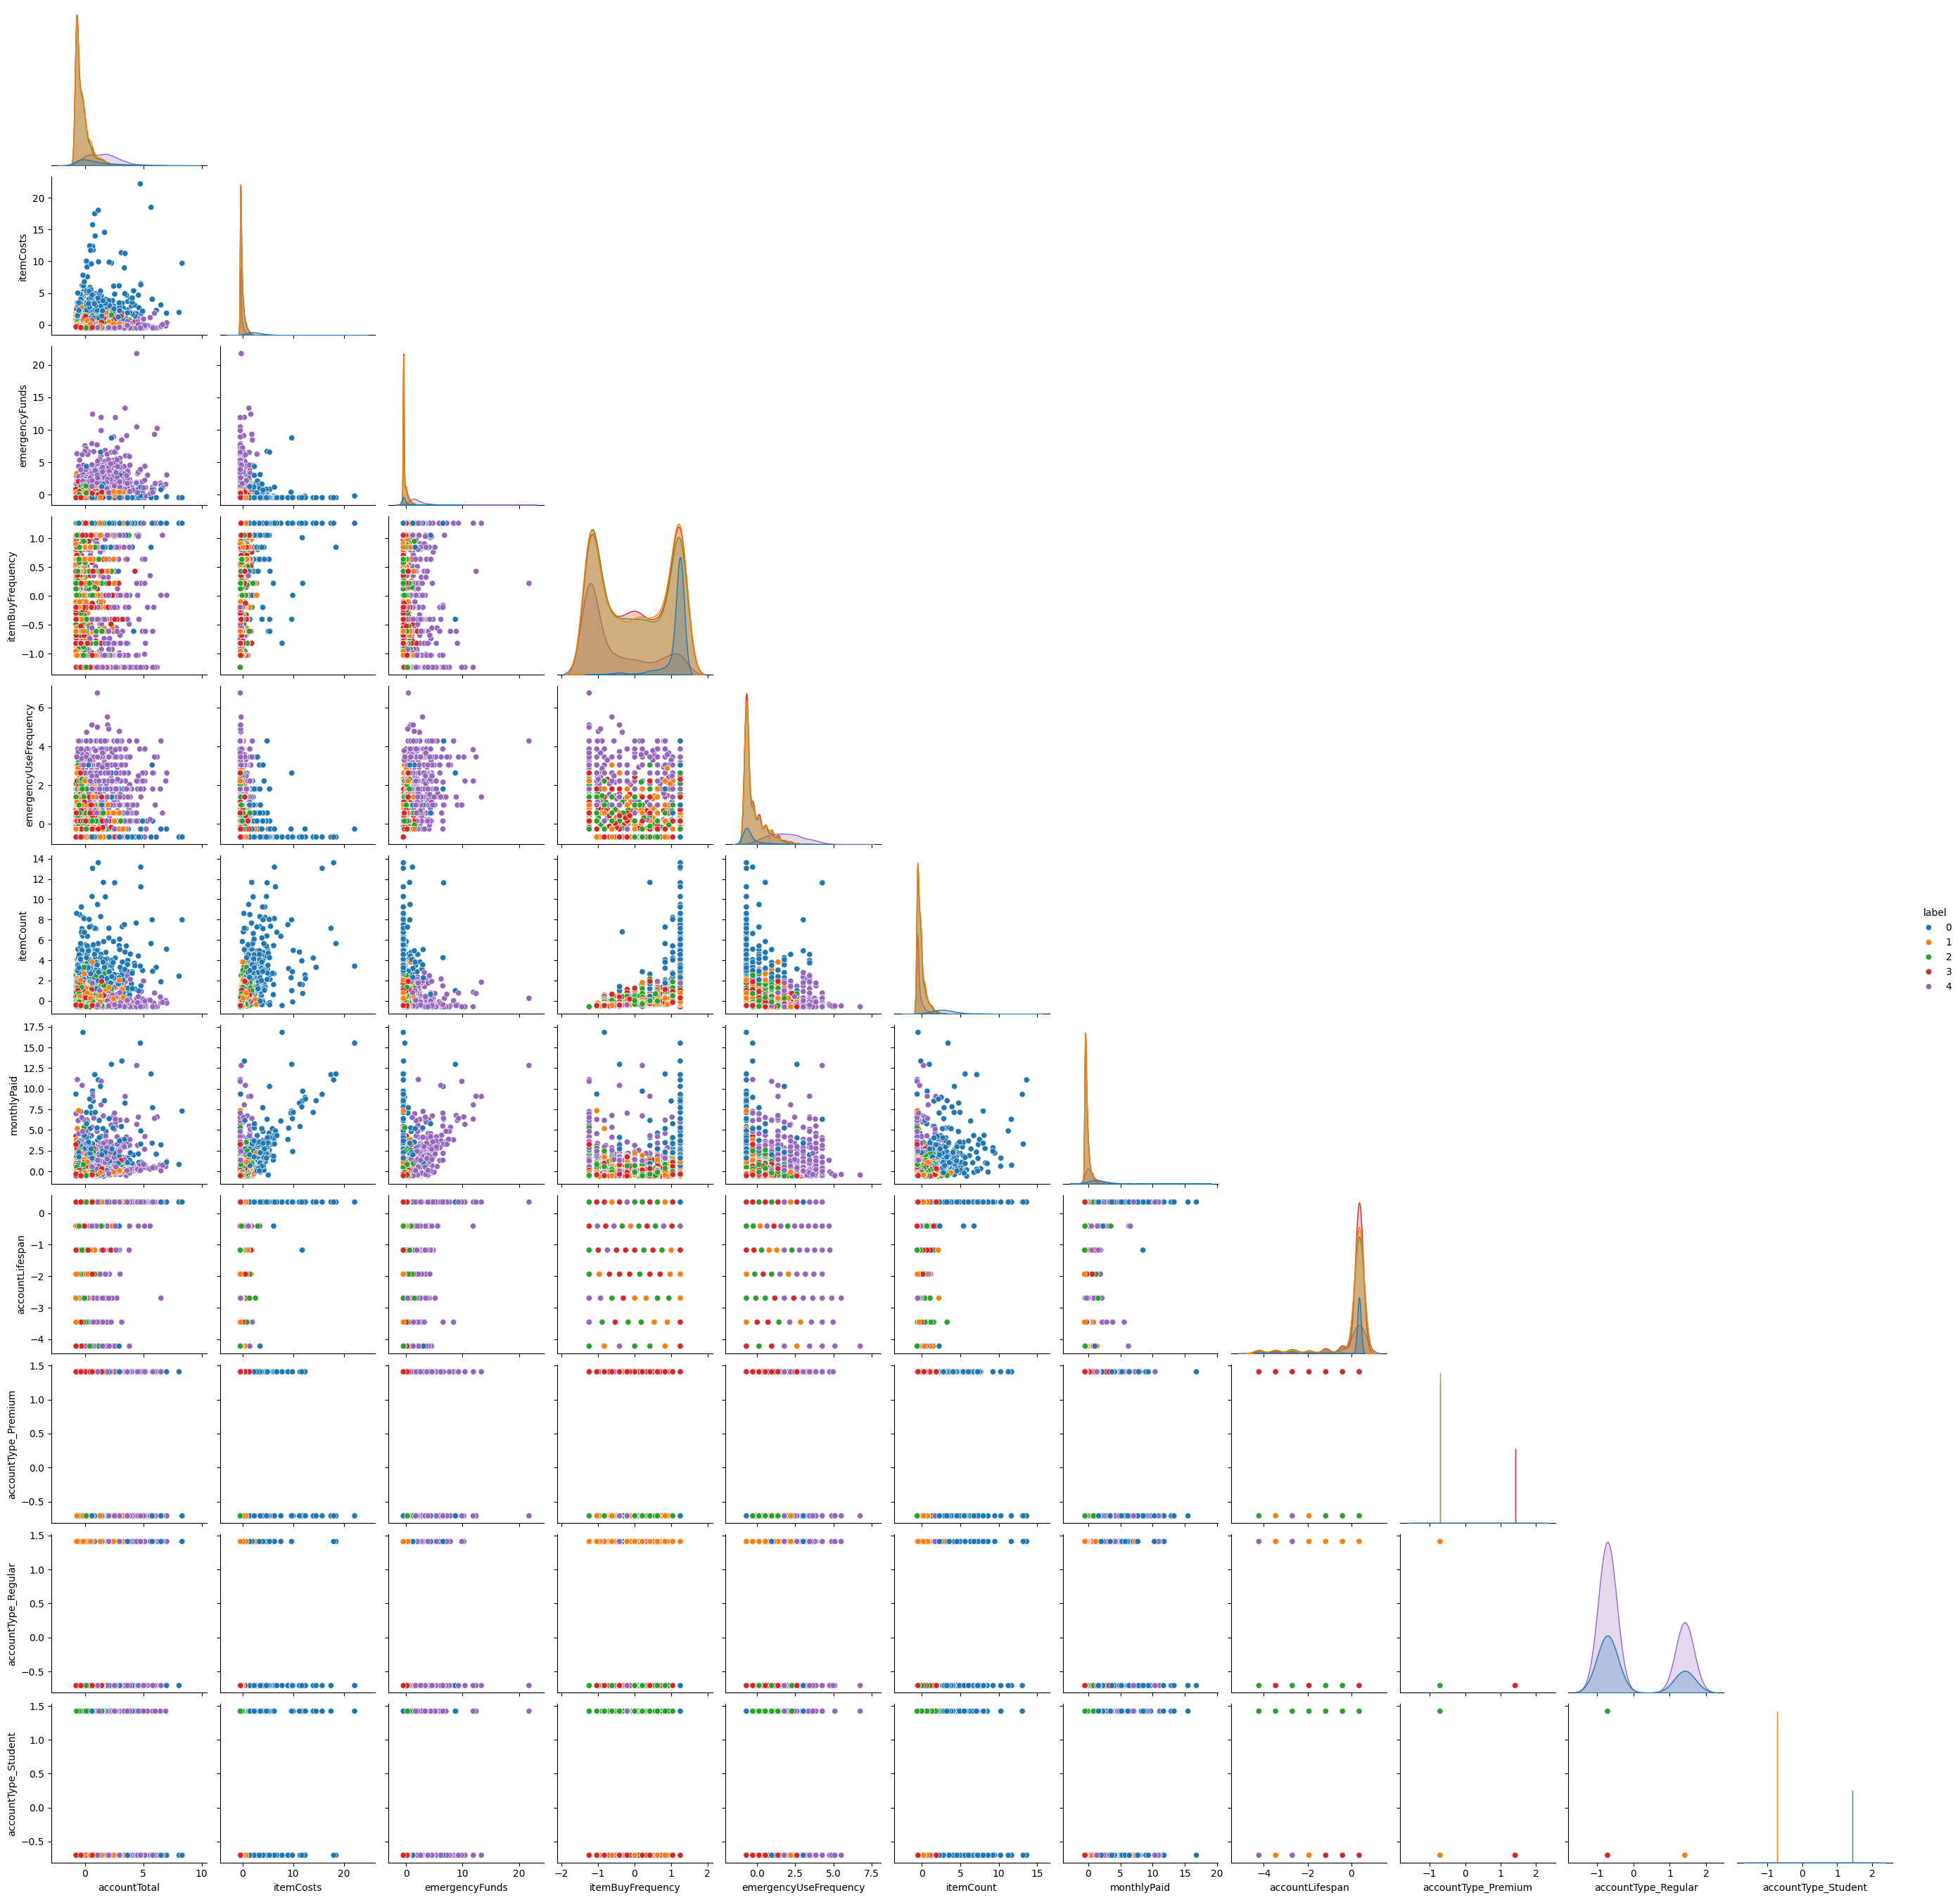

In [22]:
model = KMeans(n_clusters = 5, n_init = 'auto', init= "k-means++")

labels_pred = model.fit_predict(scaled_df2)
scaled_df2['label'] = labels_pred

unique_labels = np.unique(labels_pred)
n_unique_labels = len(unique_labels)
palette = sns.color_palette("tab10", n_colors = n_unique_labels)

sns.pairplot(scaled_df2, hue = 'label', corner = 'True', palette = palette)

The code below calculates the silhouette score for K-Means Clustering++, which is how similar an object is to its own cluster compared to other clusters. We discuss what exactly this score means for the clusters in the readme file.

In [23]:
silhouette_avg = silhouette_score(scaled_df2.drop('label', axis=1), labels_pred)

print("The average silhouette_score for K-Means++ is :", silhouette_avg)


The average silhouette_score for K-Means++ is : 0.3307839762086512


We calculate the mean of every feature prior to clustering, as well as the mean of every feature, when they are grouped by clusters. We then compare these values for every cluster and output whether each cluster’s features are below average or above average when compared to the mean. This is printed out in a nice and readable format. We wil use this information to gain insight into the meaning of these clusters, which is discussed in the readme file.

In [24]:
cluster_means = scaled_df2.groupby('label').mean()

overall_means = scaled_df2.drop('label', axis=1).mean()

cluster_characteristics = {}
for cluster_label in unique_labels:
    cluster_characteristics[cluster_label] = {
        'above_average': cluster_means.columns[(cluster_means.loc[cluster_label] > overall_means)],
        'below_average': cluster_means.columns[(cluster_means.loc[cluster_label] < overall_means)]
    }

for cluster_label in cluster_characteristics:
    print(f"\033[1m Cluster \033[0m{cluster_label}:")
    print("\033[1m Below average features: \033[0m")
    for feature in cluster_characteristics[cluster_label]['below_average']:
        print(f"- {feature}")
    print("\033[1m Above average features: \033[0m")
    for feature in cluster_characteristics[cluster_label]['above_average']:
        print(f"- {feature}")
    print("\n")

 Cluster 0:
 Below average features: 
- emergencyFunds
- emergencyUseFrequency
- accountType_Regular
 Above average features: 
- accountTotal
- itemCosts
- itemBuyFrequency
- itemCount
- monthlyPaid
- accountLifespan
- accountType_Premium
- accountType_Student


 Cluster 1:
 Below average features: 
- accountTotal
- itemCosts
- emergencyFunds
- emergencyUseFrequency
- itemCount
- monthlyPaid
- accountLifespan
- accountType_Premium
- accountType_Student
 Above average features: 
- itemBuyFrequency
- accountType_Regular


 Cluster 2:
 Below average features: 
- accountTotal
- itemCosts
- emergencyFunds
- itemBuyFrequency
- emergencyUseFrequency
- itemCount
- monthlyPaid
- accountLifespan
- accountType_Premium
- accountType_Regular
 Above average features: 
- accountType_Student


 Cluster 3:
 Below average features: 
- accountTotal
- itemCosts
- emergencyFunds
- emergencyUseFrequency
- itemCount
- monthlyPaid
- accountType_Regular
- accountType_Student
 Above average features: 
- itemBuy

## Clustering Method 2: DB-Scan

We firstly need to find an optimal value for the parameter eps, which is an input value which defines the maximum distance between two samples for them to be considered as in the same neighborhood; essentially how close points should be to each other to be considered part of a cluster. We find the distance to the nearest point for each point in the dataset, sort it by distance and plot the graph. In the graph, the elbow is at the point where the curve starts to ascent rapidly. Selecting an eps value just before this sharp increase gives us the best clustering results, as it balances the density requirement for clusters without merging separate clusters or including too much noise. We have located it to be around the value of 1.8.

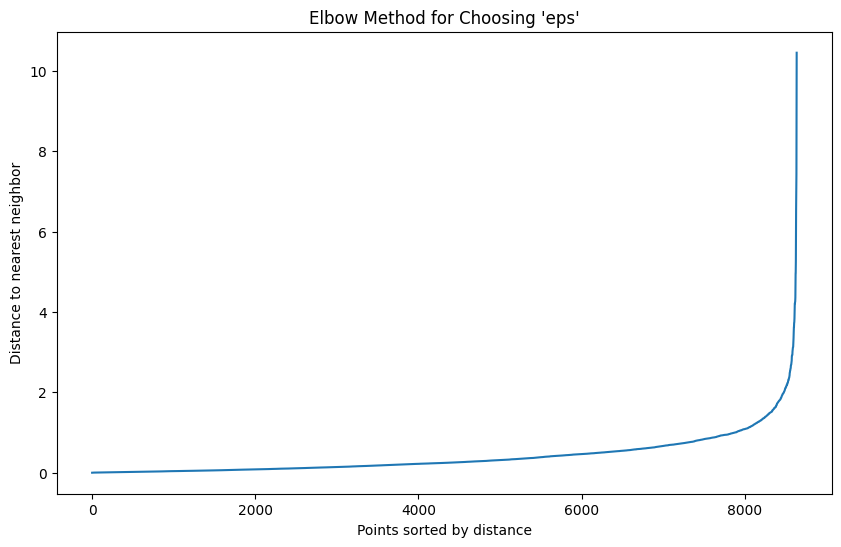

In [25]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_df3)
distances, indices = nbrs.kneighbors(scaled_df3)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("Elbow Method for Choosing 'eps'")
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to nearest neighbor')
plt.show()

Here we actually perform DBScan. Our eps value 1.8, which is above and the min_samples value, which is the amount of points to be in a neighborhood to be considered a cluster, is set to 12. That is because usually the value is the amount of features that we’re considering + 1 (11 + 1 = 12). DBScan is run and a scatter plot is created for each cluster. Points are colored differently based on their assigned cluster. Noise points are labeled separately. Each cluster and the noise points are plotted on the first two features, so that we can have some visual cue that our training has worked (doesn’t matter what the features are).


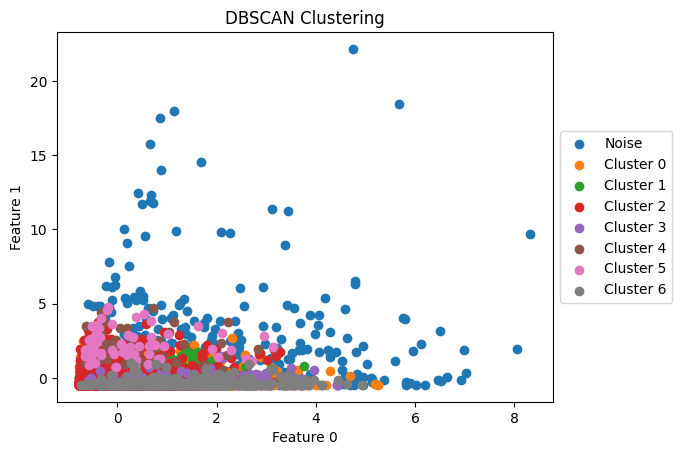

In [26]:
clustering_method = DBSCAN(eps = 1.8, min_samples = 12)
clustering_method.fit(scaled_df3)
predicted_classes = clustering_method.labels_
unique_labels = np.unique(predicted_classes)


fig, ax = plt.subplots()
for cls in unique_labels:
    class_indices = predicted_classes == cls
    if np.any(class_indices):
        ax.scatter(scaled_df3.iloc[class_indices, 0], scaled_df3.iloc[class_indices, 1],
                   label='Noise' if cls == -1 else f'Cluster {cls}')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')

plt.show()

However, the scatter plot above does not allow us to defer plausible information about the clusters, so we additionally  count the number of noise points and present them as the percentage of all points, which is what is displayed below.

In [27]:
noise_points_count = (predicted_classes == -1).sum()
percentage = str(round((noise_points_count/8636)*100, 3))

'Number of noise points: ' + str(noise_points_count)
'This is ' + percentage + "% of all of the data points."

'This is 4.898% of all of the data points.'

Additionally, we print the cluster sizes, which shows just how unbalanced each cluster is and that this method does not provide us with practical and balanced clusters, so we decided to also compute clusters using hierarchical clustering instead.

In [28]:
cluster_sizes = pd.Series(predicted_classes).value_counts()
print(cluster_sizes)

 0    2680
 2    2546
 1    2404
-1     423
 6     235
 3     204
 5      78
 4      66
Name: count, dtype: int64


This computes the Silhouette Score of DB-Scan. More on that in the readme file.

In [29]:
filter = predicted_classes != -1
filtered_data = scaled_df3[filter]
filtered_labels = predicted_classes[filter]

silhouette_avg = silhouette_score(filtered_data, filtered_labels)
print("The average silhouette_score for DB-Scan is :", silhouette_avg)

The average silhouette_score for DB-Scan is : 0.36527566427569746


## Clustering Method 3: Hierarchical Clustering 

This is the computation of hierarchical clustering. Its output is a dendrogram, which shows the euclidean distance as the y-axis and point index as the x-axis. By observation, we can cut the dendrogram short when five clusters are created and that is what we will use for our hierarchical model.

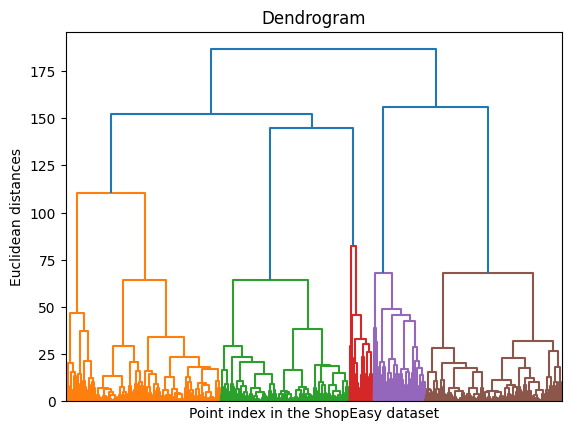

In [30]:

fig, ax = plt.subplots()
linkage_method = sch.linkage(scaled_df4, method = 'ward', metric = 'euclidean')
dendrogram = sch.dendrogram(linkage_method, ax = ax)
ax.set_title('Dendrogram')
ax.set_xlabel('Point index in the ShopEasy dataset')
ax.set_ylabel('Euclidean distances')
ax.set_xticks([])
plt.show()

We visualize the clusters we have attained through the heirachical clustering, similar to the visualization we had attained through DB-Scan.

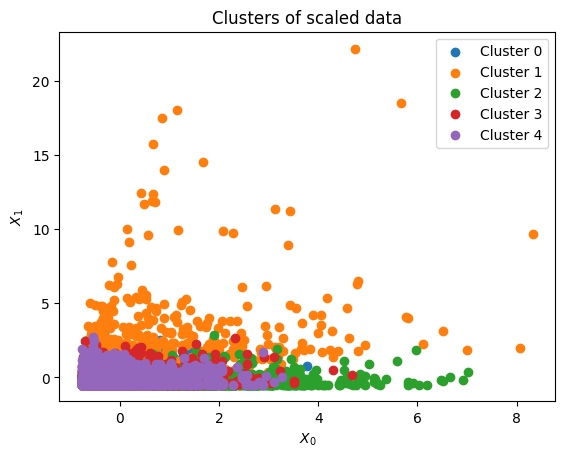

In [31]:
hierarchy_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
y_predicted = hierarchy_model.fit_predict(scaled_df4)

scaled_df4['label'] = y_predicted

fig, ax = plt.subplots()
unique_labels = np.unique(y_predicted)

for cls in unique_labels:
    cluster_data = scaled_df4.loc[y_predicted == cls, scaled_df4.columns[:2]]
    ax.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cls}')

ax.set_title('Clusters of scaled data')
ax.set_xlabel(r'$X_0$')
ax.set_ylabel(r'$X_1$')
ax.legend()
plt.show()

As we had done for K-Means, we create pairplots for all of our features (x-axis and y-axis), so that we can show all five different clusters mapped to the different features. This is displayed below.

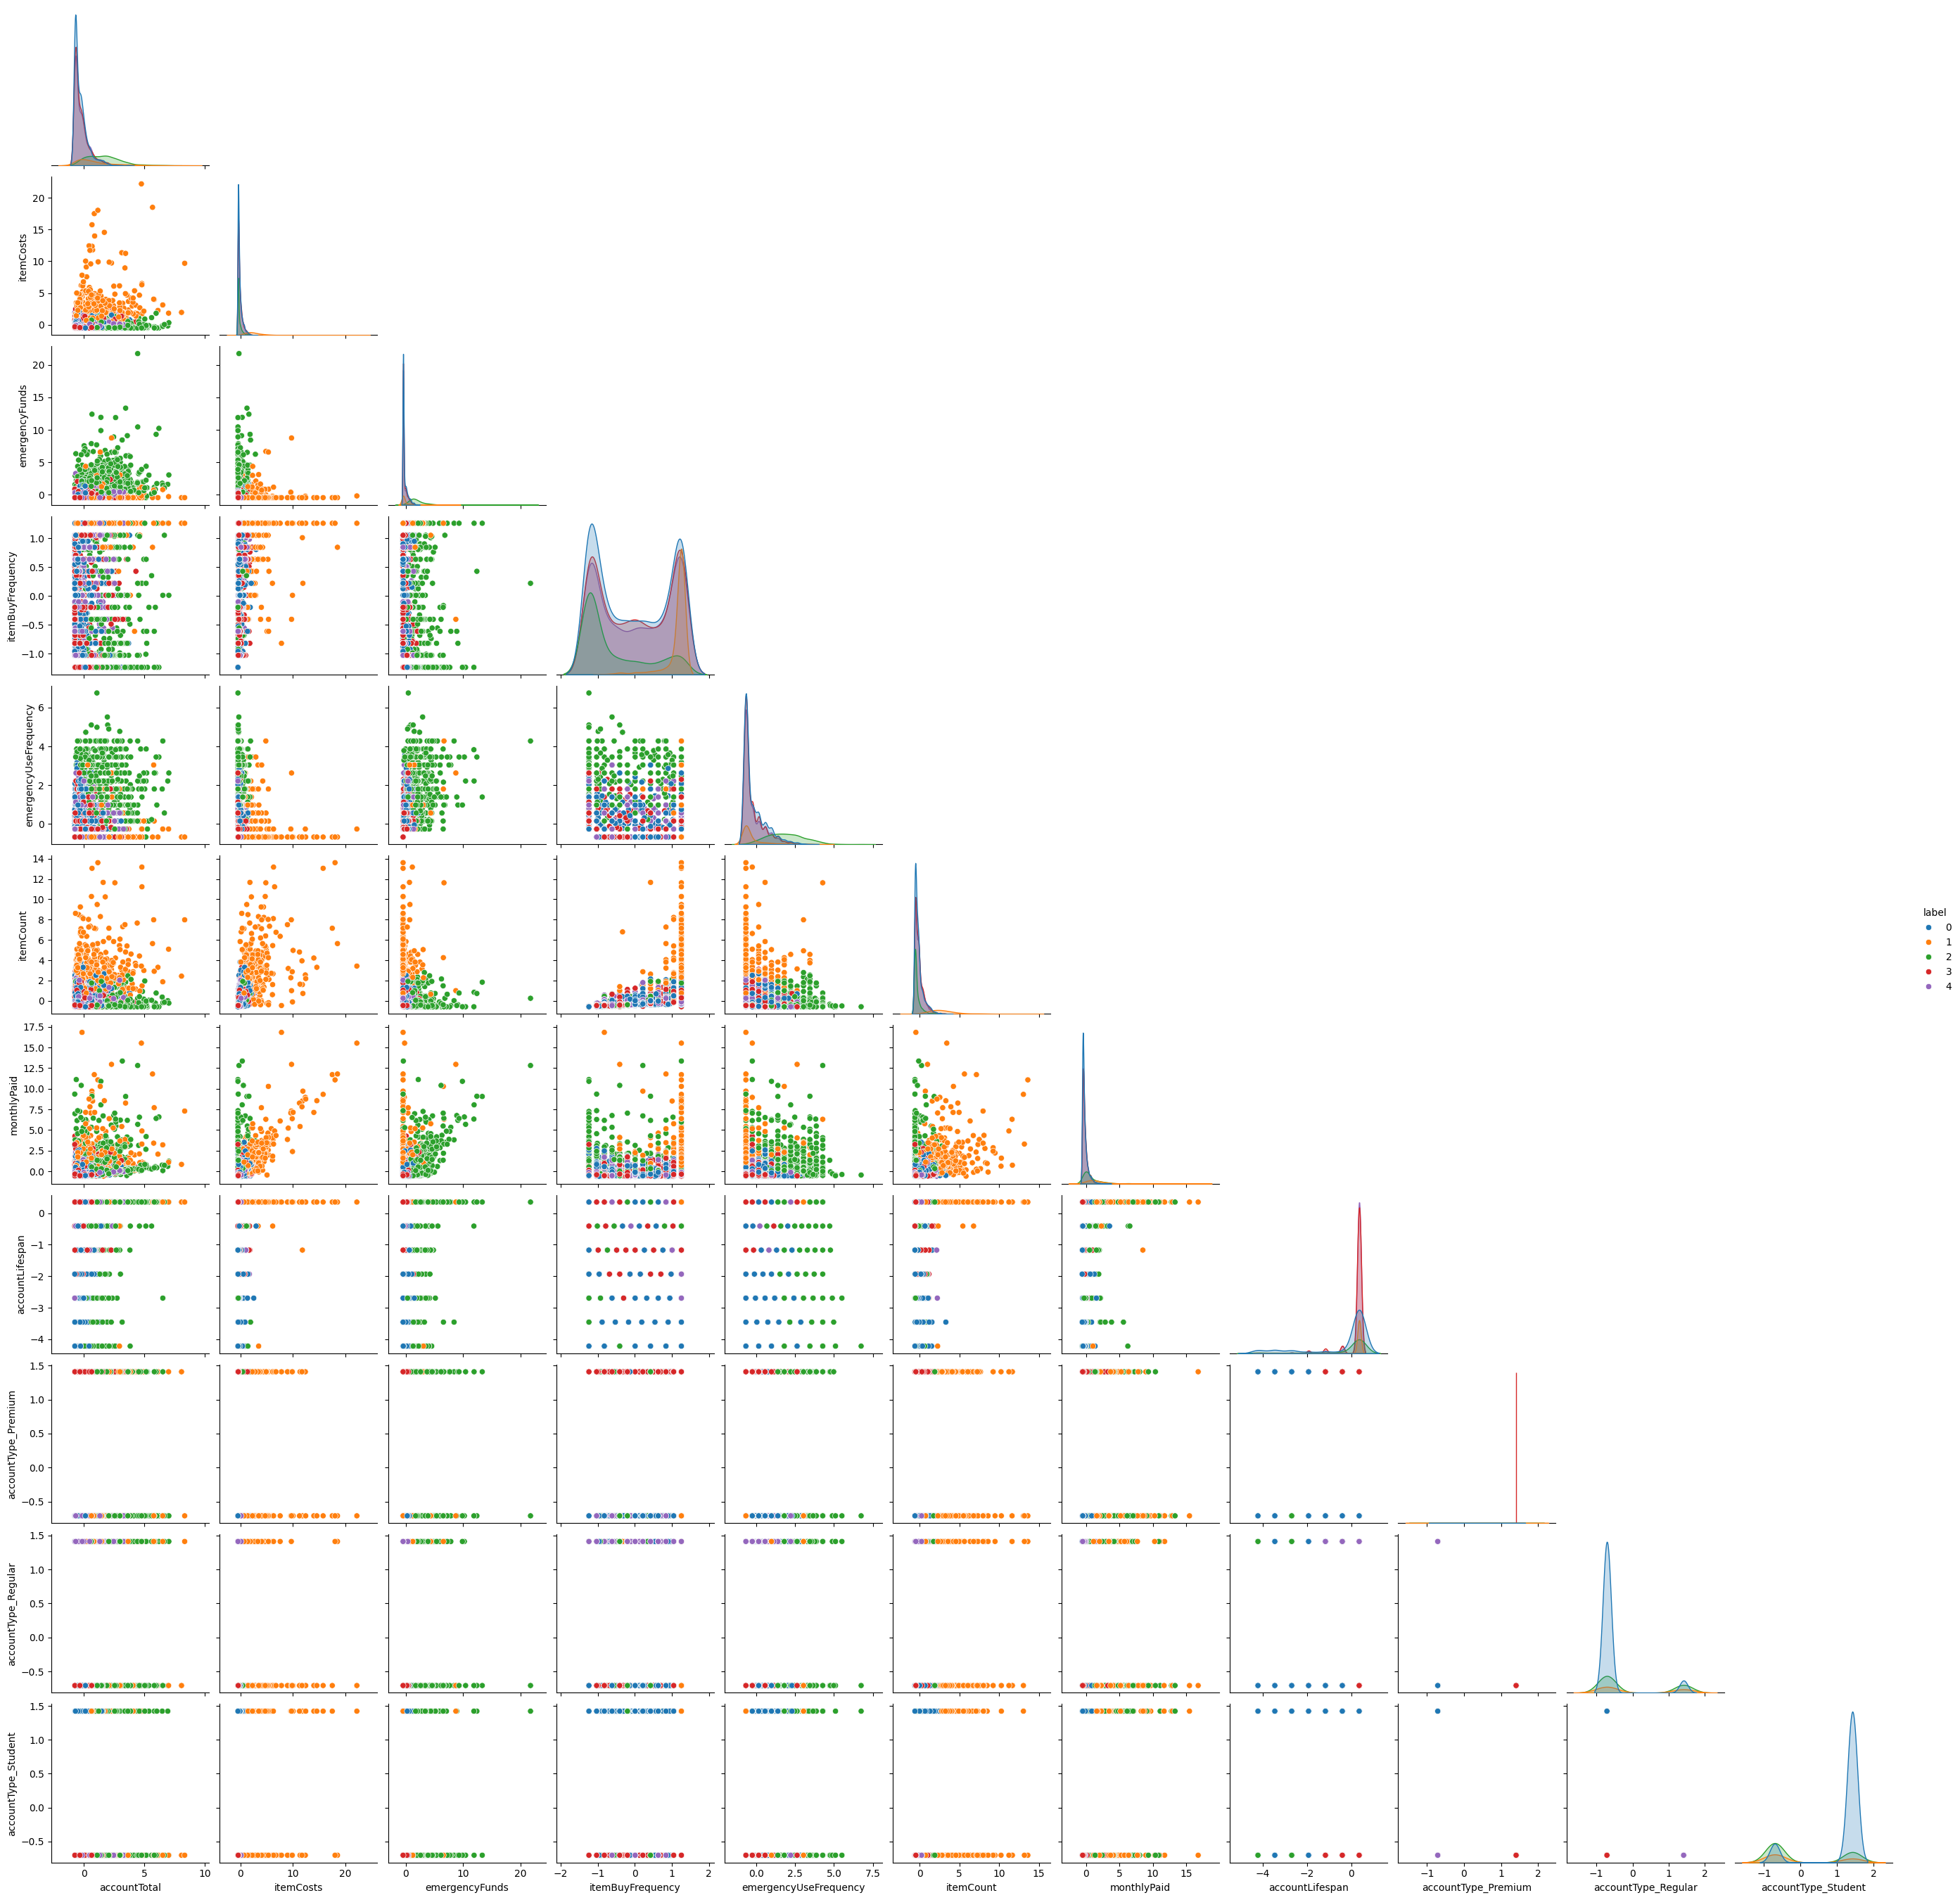

In [32]:
unique_labels = np.unique(y_predicted)
n_unique_labels = len(unique_labels)
palette = sns.color_palette("tab10", n_colors=n_unique_labels)

pair_plot = sns.pairplot(scaled_df4, hue='label', corner=True, palette=palette)
plt.show()

Again, we go ahead and calculate the mean of every feature prior to clustering, as well as the mean of every feature, when they are grouped by clusters and print out the below average and above average features of each cluster. We can see that when we compare it to our K-Means Clustering clusters, there’s only one slight difference explained in the readme file.

In [33]:
cluster_means = scaled_df4.groupby('label').mean()

overall_means = scaled_df4.drop('label', axis=1).mean()

cluster_characteristics = {}
for cluster_label in unique_labels:
    cluster_characteristics[cluster_label] = {
        'above_average': cluster_means.columns[(cluster_means.loc[cluster_label] > overall_means)],
        'below_average': cluster_means.columns[(cluster_means.loc[cluster_label] < overall_means)]
    }

for cluster_label in cluster_characteristics:
    print(f"\033[1m Cluster \033[0m{cluster_label}:")
    print("\033[1m Below average features: \033[0m")

    for feature in cluster_characteristics[cluster_label]['below_average']:
        print(f"- {feature}")
    print("\033[1m Above average features: \033[0m")

    for feature in cluster_characteristics[cluster_label]['above_average']:
        print(f"- {feature}")
    print("\n")


 Cluster 0:
 Below average features: 
- accountTotal
- itemCosts
- emergencyFunds
- itemBuyFrequency
- emergencyUseFrequency
- itemCount
- monthlyPaid
- accountLifespan
- accountType_Premium
- accountType_Regular
 Above average features: 
- accountType_Student


 Cluster 1:
 Below average features: 
- emergencyFunds
- emergencyUseFrequency
- accountType_Premium
- accountType_Student
 Above average features: 
- accountTotal
- itemCosts
- itemBuyFrequency
- itemCount
- monthlyPaid
- accountLifespan
- accountType_Regular


 Cluster 2:
 Below average features: 
- itemCosts
- itemBuyFrequency
- itemCount
- accountLifespan
- accountType_Premium
- accountType_Regular
 Above average features: 
- accountTotal
- emergencyFunds
- emergencyUseFrequency
- monthlyPaid
- accountType_Student


 Cluster 3:
 Below average features: 
- accountTotal
- itemCosts
- emergencyFunds
- emergencyUseFrequency
- itemCount
- monthlyPaid
- accountType_Regular
- accountType_Student
 Above average features: 
- itemBuy

This computes the Silhouette Score of Hierarchical Clustering. More on that in the readme file.

In [34]:
silhouette_avg = silhouette_score(scaled_df4.drop('label', axis=1), y_predicted)

print("The average silhouette_score for Hierarchical Clustering is :", silhouette_avg)

The average silhouette_score for Hierarchical Clustering is : 0.3033266750200659
